In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

C:\Users\uma\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load data file and assign column names
# 1. Sample code number: id number
# 2. Clump Thickness: 1 - 10
# 3. Uniformity of Cell Size: 1 - 10
# 4. Uniformity of Cell Shape: 1 - 10
# 5. Marginal Adhesion: 1 - 10
# 6. Single Epithelial Cell Size: 1 - 10
# 7. Bare Nuclei: 1 - 10 
# 8. Bland Chromatin: 1 - 10
# 9. Normal Nucleoli: 1 - 10
# 10. Mitoses: 1 - 10
# 11. Class: (2 for benign, 4 for malignant)

wisc_data = pd.read_csv('breast-cancer-wisconsin.csv', header = None)
wisc_data.columns = ["id", "thickness", "cell_size", "cell_shape", "adhesion", 
                     "single_cell_size", "bare_nuclei", "chromatin", "normal_nuceloli",
                     "mitoses", "class"]

In [3]:
# Check if data looks ok
wisc_data.head()

,id,thickness,cell_size,cell_shape,adhesion,single_cell_size,bare_nuclei,chromatin,normal_nuceloli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
# Check if it loded correctly - should be 699 rows and 11 columns
wisc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
id                  683 non-null int64
thickness           683 non-null int64
cell_size           683 non-null int64
cell_shape          683 non-null int64
adhesion            683 non-null int64
single_cell_size    683 non-null int64
bare_nuclei         683 non-null int64
chromatin           683 non-null int64
normal_nuceloli     683 non-null int64
mitoses             683 non-null int64
class               683 non-null int64
dtypes: int64(11)
memory usage: 58.8 KB


In [5]:
# Basic descriptives
wisc_data.describe()

,id,thickness,cell_size,cell_shape,adhesion,single_cell_size,bare_nuclei,chromatin,normal_nuceloli,mitoses,class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


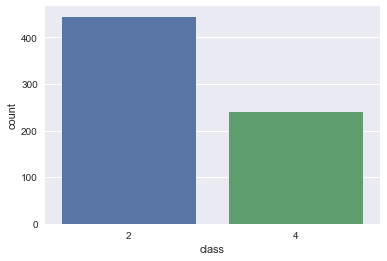

In [6]:
# lets get the frequency of cancer stages
sns.countplot(wisc_data['class'],label="Count")

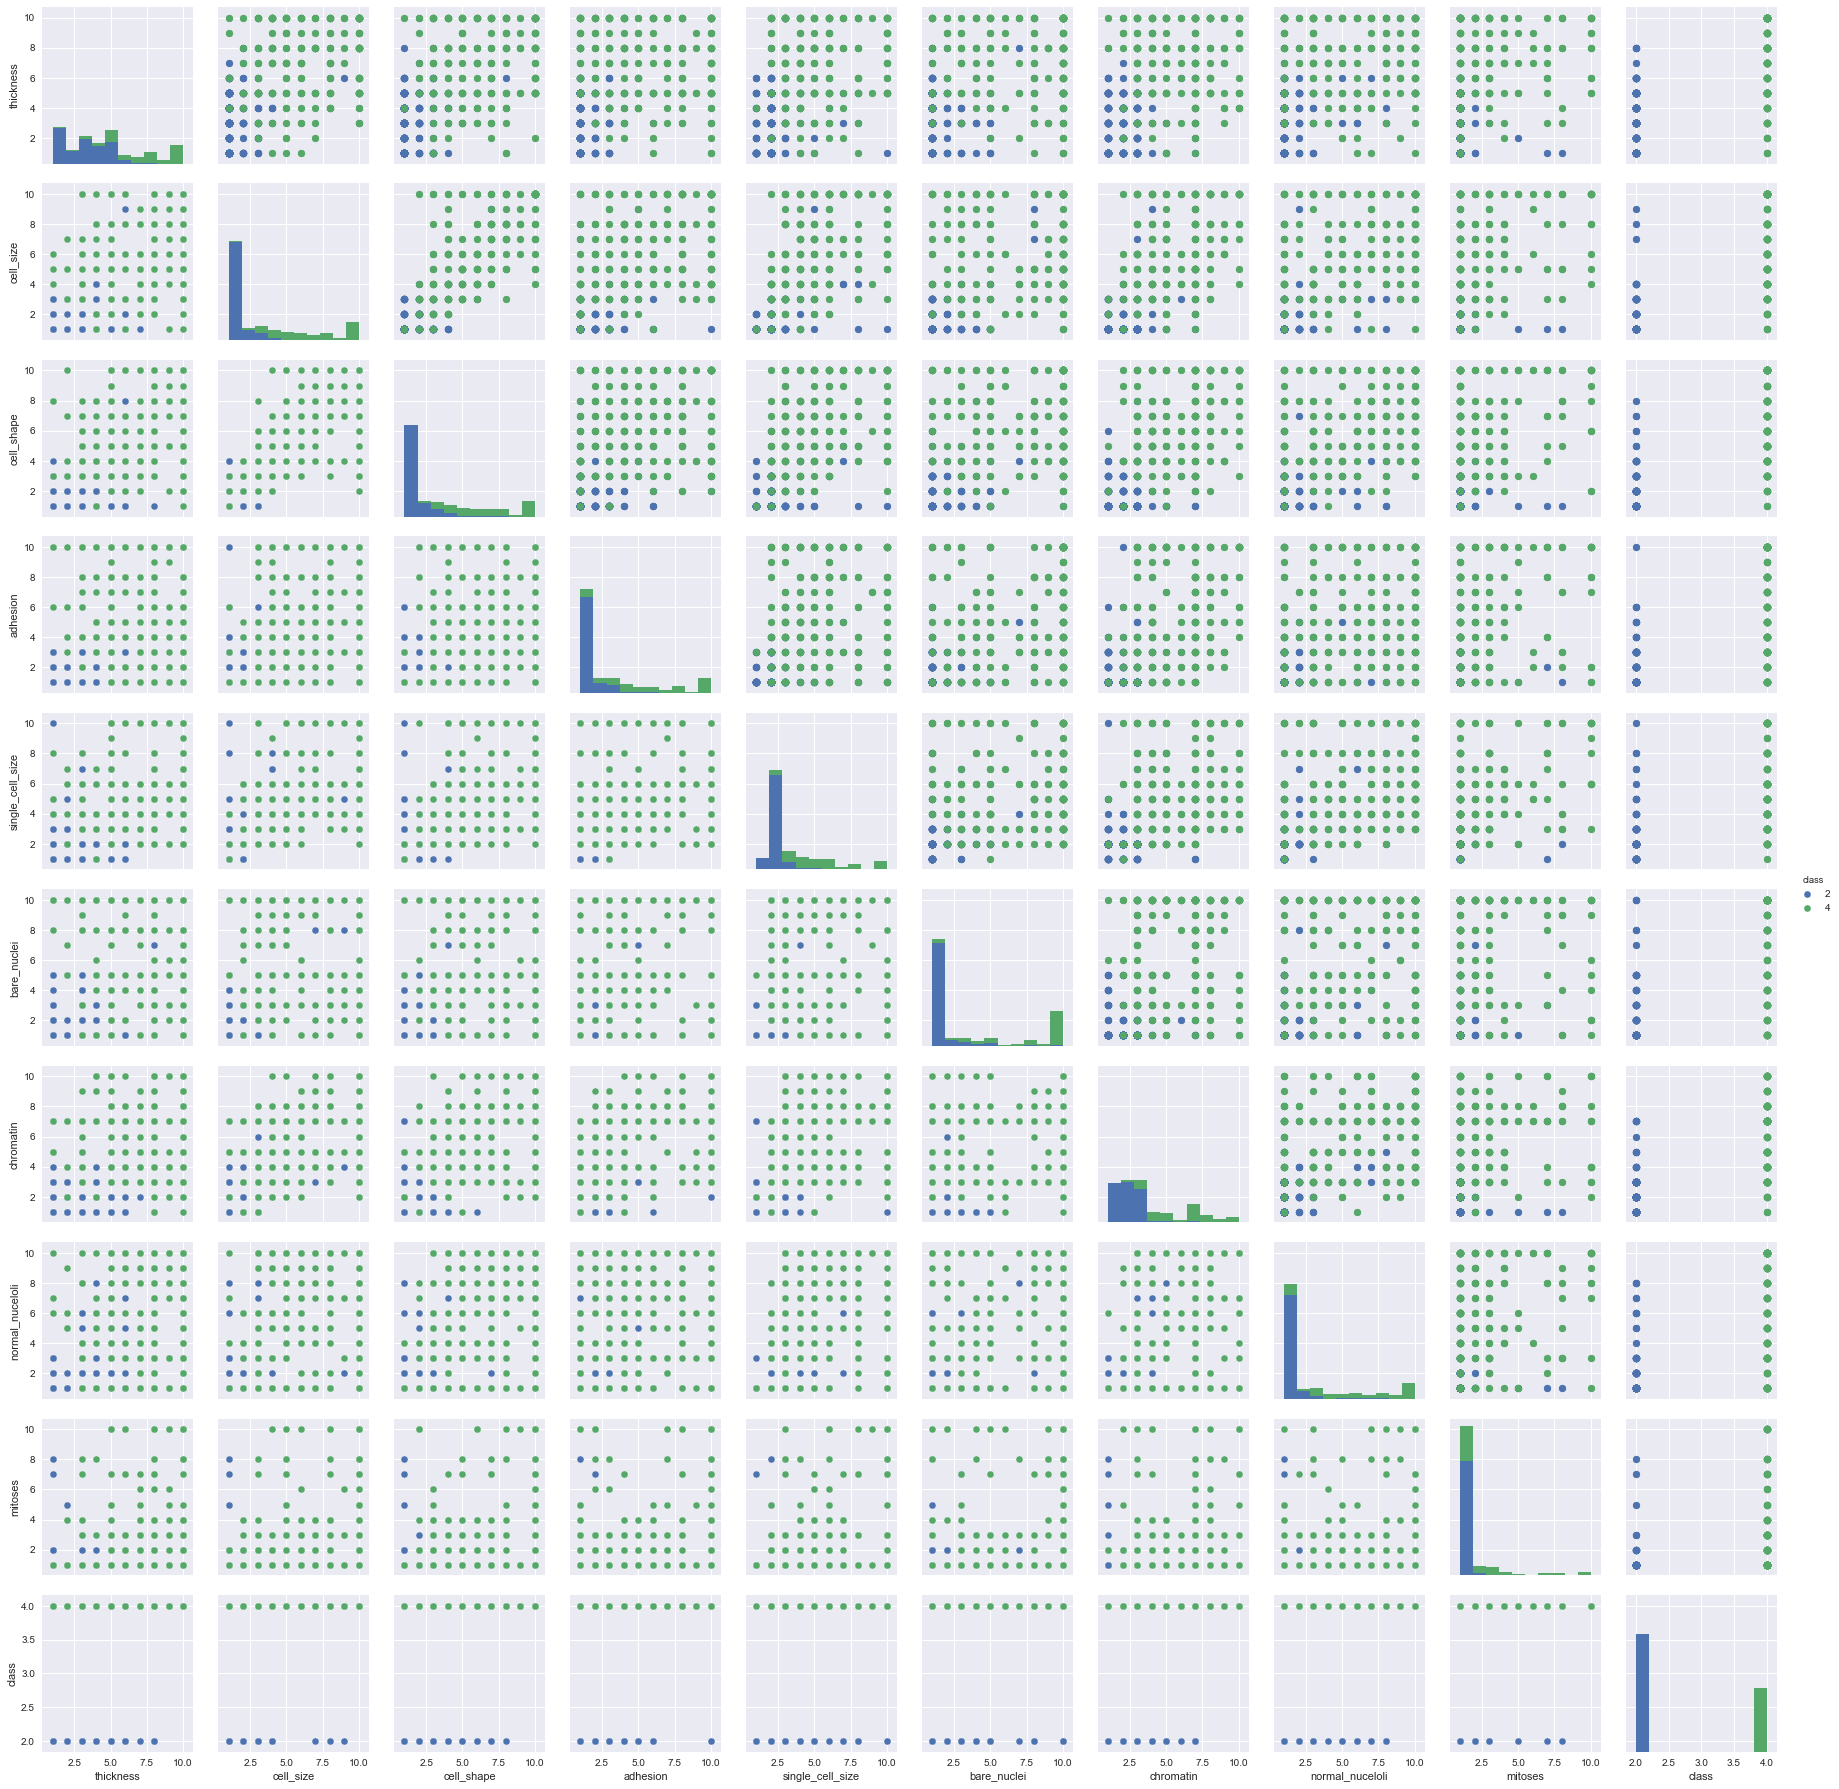

In [7]:
# Pairplot which looks at histogram and scatter of all variables together
g = sns.pairplot(wisc_data[wisc_data.columns[1:11]], hue = 'class')
g.map_diag(plt.hist)
g.map_upper(plt.scatter)

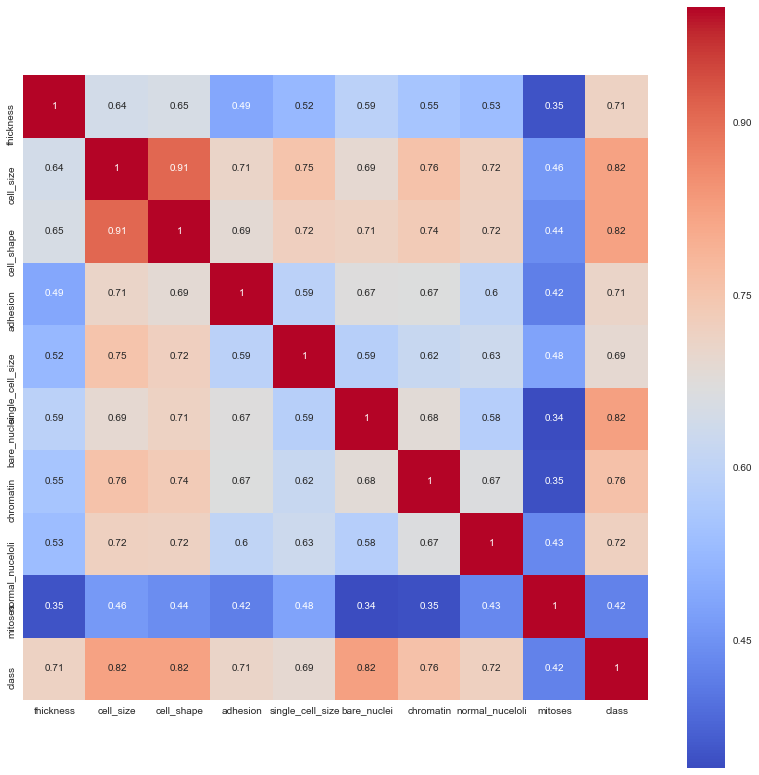

In [8]:
# Print out a heatmap with correlations superimposed
# Correlations not best measure but since skews are similar in shape,
# still tells you relationship between variables
wisc_corr = wisc_data[wisc_data.columns[1:11]].corr()
plt.figure(figsize=(14,14))
sns.heatmap(wisc_corr, cbar = True, square = True, annot=True, cmap= 'coolwarm') 

C:\Users\uma\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


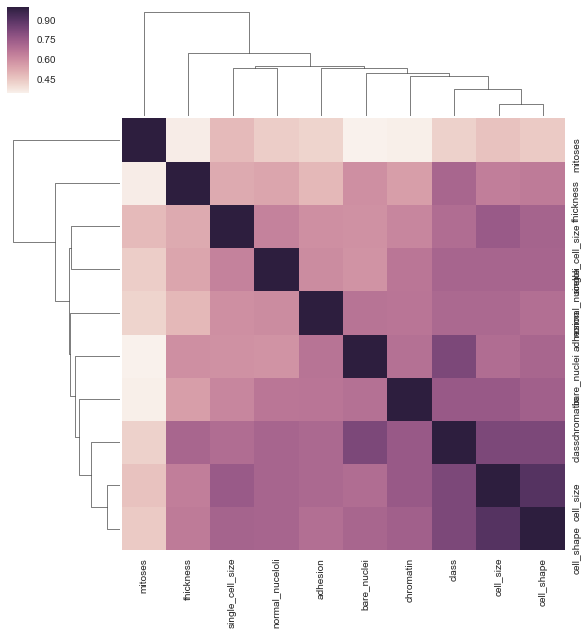

In [9]:
# Print out a hierarchical cluster map uisng heat map data above
sns.clustermap(wisc_corr)

In [10]:
# Since lowest correlation amongst varibles is about 0.3, for a first pass I decided to
# enter all 10 variables to predict class. Next pass, I might skip one or two of highly 
# correlated, depending on results
prediction_var = ["thickness", "cell_size", "cell_shape", "adhesion", 
                     "single_cell_size", "bare_nuclei", "chromatin", "normal_nuceloli",
                     "mitoses"]

# Split data into training set and test set
train, test = train_test_split(wisc_data, test_size = 0.3)
print(train.shape)
print(test.shape)

(478, 11)
(205, 11)


In [11]:
# Define training data
train_X = train[prediction_var] 
train_y = train['class']

# Define test data
test_X = test[prediction_var] 
test_y = test['class']

In [12]:
# Fit a random forest model
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [13]:
# Fit model to test data
prediction = model.predict(test_X)

In [14]:
metrics.accuracy_score(prediction, test_y)

0.95609756097560972

In [15]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_y, prediction))

             precision    recall  f1-score   support

          2       0.97      0.96      0.97       138
          4       0.93      0.94      0.93        67

avg / total       0.96      0.96      0.96       205



In [16]:
# Check which features out of all features seemed best
whichfeat = pd.Series(model.feature_importances_, index=prediction_var).sort_values(ascending=False)
print(whichfeat)

cell_shape          0.256523
cell_size           0.231812
bare_nuclei         0.208326
chromatin           0.104417
normal_nuceloli     0.076427
single_cell_size    0.066555
thickness           0.035505
adhesion            0.016617
mitoses             0.003818
dtype: float64


In [17]:
# I tried keeping just the features which were best predictors. As you can see below,
# accuracy takes a very slight hit when I decrease # of predictors.
small_prediction_var=['cell_shape','cell_size','bare_nuclei']  

small_train_X= train[small_prediction_var]
small_train_y= train['class']
small_test_X = test[small_prediction_var]
small_test_y = test['class']

small_model = RandomForestClassifier(n_estimators=100)
model.fit(small_train_X,small_train_y)
small_prediction = model.predict(small_test_X)
metrics.accuracy_score(small_prediction, small_test_y)

0.95609756097560972

In [18]:
# I reduced it even more here. As you can see, cell shape and cell_size together
# do an excellent job of predicting cancerous vs benign cells
super_small_prediction_var=['cell_shape','cell_size']  

super_small_train_X= train[super_small_prediction_var]
super_small_train_y= train['class']
super_small_test_X = test[super_small_prediction_var]
super_small_test_y = test['class']

super_small_model = RandomForestClassifier(n_estimators=100)
model.fit(super_small_train_X, super_small_train_y)
super_small_prediction = model.predict(super_small_test_X)
metrics.accuracy_score(super_small_prediction, super_small_test_y)

0.92195121951219516

In [19]:
# Function that prints accuracy and cross-validation scores for 5-fold validation
# for a bunch of different models listed below with all predictors
def classification_model(model, data, prediction_input, output):
    #Fit the model using training set
    model.fit(data[prediction_input],data[output]) 
    predictions = model.predict(data[prediction_input])
  
    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[output])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))
 
    # 5 fold cross validation
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        train_X = (data[prediction_input].iloc[train,:])
        train_y = data[output].iloc[train]
        model.fit(train_X, train_y)
    
        # now do this for test data also
        test_X=data[prediction_input].iloc[test,:]
        test_y=data[output].iloc[test]
        error.append(model.score(test_X,test_y))
        
        # printing the score 
        print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

In [20]:
# Decision Tree
model = DecisionTreeClassifier()
outcome_var= "class"
classification_model(model, wisc_data, prediction_var, outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 91.241%
Cross-Validation Score : 93.066%
Cross-Validation Score : 92.457%
Cross-Validation Score : 93.608%
Cross-Validation Score : 93.857%


In [21]:
# Support Vector Machine
model = svm.SVC()
classification_model(model, wisc_data, prediction_var, outcome_var)

Accuracy : 99.561%
Cross-Validation Score : 91.241%
Cross-Validation Score : 92.701%
Cross-Validation Score : 93.917%
Cross-Validation Score : 94.519%
Cross-Validation Score : 95.321%


In [22]:
# K Nearest Neighbors
model = KNeighborsClassifier()
classification_model(model, wisc_data, prediction_var, outcome_var)

Accuracy : 97.950%
Cross-Validation Score : 93.431%
Cross-Validation Score : 95.255%
Cross-Validation Score : 95.620%
Cross-Validation Score : 96.164%
Cross-Validation Score : 96.784%


In [23]:
# Random Forest, which we used here
model = RandomForestClassifier(n_estimators=100)
classification_model(model, wisc_data, prediction_var, outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 91.971%
Cross-Validation Score : 94.161%
Cross-Validation Score : 94.891%
Cross-Validation Score : 95.433%
Cross-Validation Score : 96.199%


In [24]:
# Logistic Regression
model = LogisticRegression()
classification_model(model, wisc_data, prediction_var, outcome_var)

Accuracy : 96.925%
Cross-Validation Score : 91.241%
Cross-Validation Score : 93.431%
Cross-Validation Score : 94.404%
Cross-Validation Score : 95.251%
Cross-Validation Score : 96.201%
